# ConvNet for image classification (CIFAR-10)  
# Forward pass to validate CNN results from TensorFlow

In [1]:
import json
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
print(f'sys.version: {sys.version}')
print(f'tf.__version__: {tf.__version__}')

sys.version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]
tf.__version__: 1.11.0


## Load CIFAR-10

In [3]:
def load_cifar10(num_training=49000, num_validation=1000, num_test=10000, shuffle=False):
    # Load the raw CIFAR-10 dataset and use appropriate data types and shapes
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Shuffle the data
    if shuffle:
        indices_train = np.arange(len(y_train))
        np.random.shuffle(indices_train)
        X_train = X_train[indices_train]
        y_train = y_train[indices_train]
        
        indices_test = np.arange(len(y_test))
        np.random.shuffle(indices_test)
        X_test = X_test[indices_test]
        y_test = y_test[indices_test]
    
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean pixel and divide by std
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel
    
    stats = {}
    stats['mean_pixel'] = mean_pixel
    stats['std_pixel'] = std_pixel
    
    # Classes
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    return X_train, y_train, X_val, y_val, X_test, y_test, classes, stats

np.random.seed(67)
X_train, y_train, X_val, y_val, X_test, y_test, classes, stats = load_cifar10(num_training=49000, 
                                                                              num_validation=1000, 
                                                                              num_test=1000, 
                                                                              shuffle=True)
random_indices = np.random.choice(len(X_train), len(X_test), replace=False)
X_train_random = X_train[random_indices]
y_train_random = y_train[random_indices]
print('Classes: ', classes)
print('Train data shape: ', X_train.shape, '[', X_train.min(), X_train.max(), ']', X_train.dtype)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Train_random_subset data shape: ', X_train_random.shape)
print('Train_random_subset labels shape: ', y_train_random.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Classes:  ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train data shape:  (49000, 32, 32, 3) [ -1.9891398 2.1265779 ] float32
Train labels shape:  (49000,) int32
Train_random_subset data shape:  (1000, 32, 32, 3)
Train_random_subset labels shape:  (1000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


## Look at some images

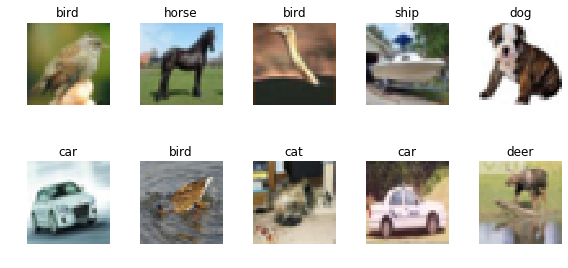

In [4]:
plt.figure(figsize=(8, 4))
batch = (X_train[0:10] * stats['std_pixel'] + stats['mean_pixel'])

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(batch[i].astype('int32'))
    plt.axis('off')
    plt.title(classes[y_train[i]])

plt.tight_layout()

## ConvNet (just forward pass)

In [5]:
INIT_METHOD = 'he_normal'
BATCH_SIZE = 64
N = len(y_train)

start_indices = list(range(0, N, BATCH_SIZE))
end_indices = list(range(BATCH_SIZE, N, BATCH_SIZE))
if end_indices[-1] != N:
    end_indices.append(N)

In [6]:
def load_weights(filename=f'./model_weights/tensorflow_weights_init_{INIT_METHOD}.txt'):
    with open(filename, 'r') as fi:
        return json.load(fi)
    
weights = load_weights()
print(weights.keys())

dict_keys(['conv1_w', 'conv1_b', 'conv2_w', 'conv2_b', 'fc3_w', 'fc3_b', 'fc4_w', 'fc4_b'])


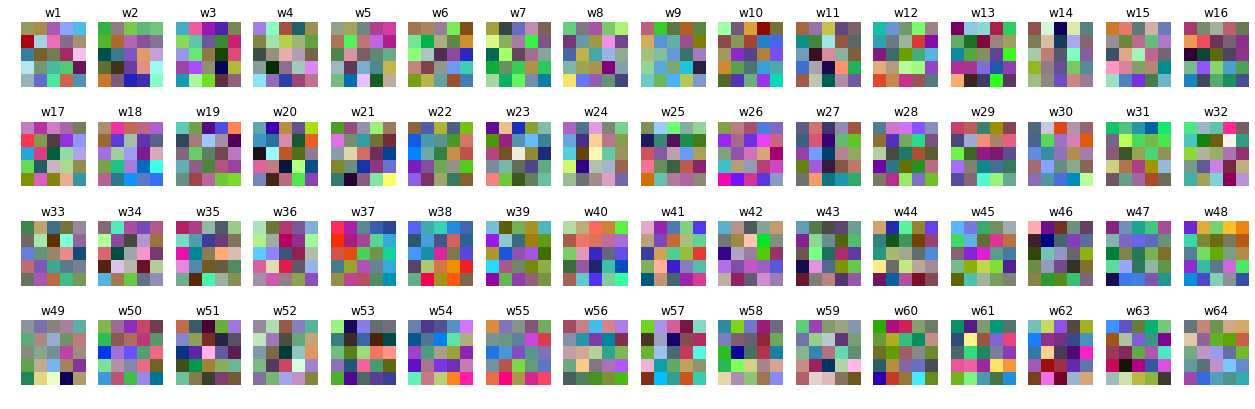

In [7]:
def normalize_img(x):
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

conv1_w = np.array(weights['conv1_w'])

plt.figure(figsize=(22, 7))
for i in range(conv1_w.shape[-1]):
    plt.subplot(4, conv1_w.shape[-1] // 4, i + 1)
    conv1_filter = normalize_img(conv1_w[:,:,:,i])
    plt.imshow(conv1_filter)
    plt.axis('off')
    plt.title(f'w{i+1}')

In [8]:
def conv_forward(x, w, b):
    N, H, W, C = x.shape
    HF, WF, C_IN, C_OUT = w.shape
    
    # HF % 2 == 1 and WH % 2 == 1
    out = np.zeros((N, H - HF + 1, W - WF + 1, C_OUT))
    
    for img_idx in range(N):
        for i in range(HF // 2, H - HF // 2):
            for j in range(WF // 2, W - WF // 2):
                x_patch = x[img_idx, 
                            i - HF // 2: i + HF // 2 + 1,
                            j - WF // 2: j + WF // 2 + 1, 
                            :]
                for k in range(C_OUT):
                    out[img_idx, i - HF // 2, j - WF // 2, k] = np.sum(x_patch * w[:,:,:,k]) + b[k]
    return out


def relu_forward(x):
    return np.maximum(0, x)


def max_pool_forward(x):
    # size = 2
    # stride = 2
    N, H, W, C = x.shape
    out = np.zeros((N, H // 2, W // 2, C))
    
    for img_idx in range(N):
        for i in range(0, H, 2):
            for j in range(0, W, 2):
                out[img_idx, i // 2, j // 2, :] = np.max(x[img_idx:img_idx+1, i:i+2, j:j+2, :], axis=(0,1,2))
    return out


def fc_forward(x, w, b):
    N = x.shape[0]
    out = np.dot(x.reshape(N, -1), w) + b
    return out


def nll(logits, y):
    N = logits.shape[0]
    shifted_logits = logits - np.max(logits, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    return loss

In [9]:
class CNN:
    def __init__(self, weights):
        self.weights = weights
        
    def forward(self, x, y=None):
        conv1_w = np.array(self.weights['conv1_w'])
        conv1_b = np.array(self.weights['conv1_b'])
        conv2_w = np.array(self.weights['conv2_w'])
        conv2_b = np.array(self.weights['conv2_b'])
        fc3_w = np.array(self.weights['fc3_w'])
        fc3_b = np.array(self.weights['fc3_b'])
        fc4_w = np.array(self.weights['fc4_w'])
        fc4_b = np.array(self.weights['fc4_b'])

        conv1 = conv_forward(x, conv1_w, conv1_b)
        relu1 = relu_forward(conv1)
        max_pool1 = max_pool_forward(relu1)
        conv2 = conv_forward(max_pool1, conv2_w, conv2_b)
        relu2 = relu_forward(conv2)
        max_pool2 = max_pool_forward(relu2)
        fc3 = fc_forward(max_pool2, fc3_w, fc3_b)
        relu3 = relu_forward(fc3)
        logits = fc_forward(relu3, fc4_w, fc4_b)
        
        y_pred = np.argmax(logits, axis=1)
        
        accuracy = None
        loss = None
        if y is not None:
            accuracy = np.mean(np.equal(y_pred, y))
            loss = nll(logits=logits, y=y)
        
        return y_pred, accuracy, loss

In [10]:
%%time
# val accuracy and loss
cnn = CNN(weights)
_, val_acc, val_loss = cnn.forward(X_val, y_val)
print(f'val_acc: {100*val_acc:.2f}%')
print(f'val_loss: {val_loss:.3f}')

val_acc: 62.50%
val_loss: 1.323
CPU times: user 4min 52s, sys: 112 ms, total: 4min 53s
Wall time: 4min 53s


In [11]:
# test conv_forward, relu_forward and max_pool_forward
x = X_train[1:2]
conv1_w = np.array(weights['conv1_w'])
conv1_b = np.array(weights['conv1_b'])
conv1 = conv_forward(x, conv1_w, conv1_b)
relu1 = relu_forward(conv1)
max_pool1 = max_pool_forward(relu1)

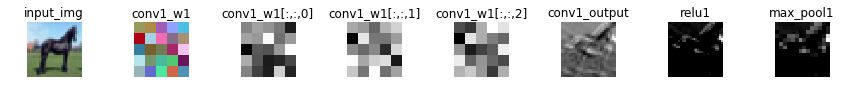

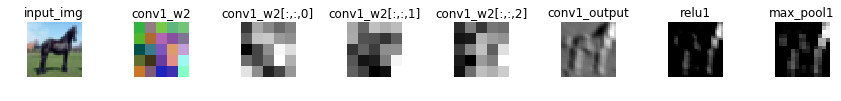

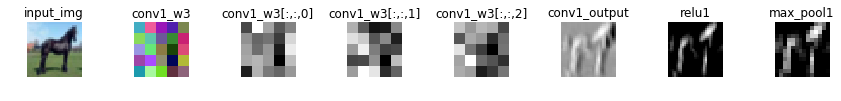

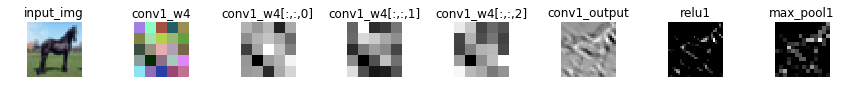

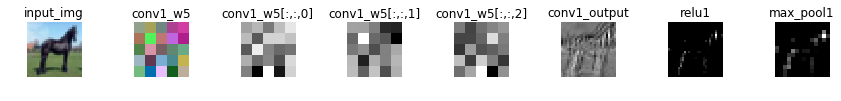

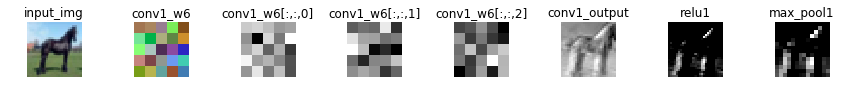

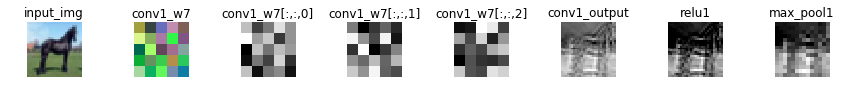

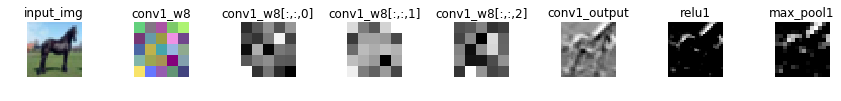

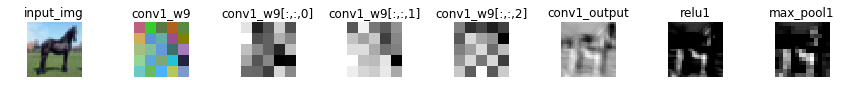

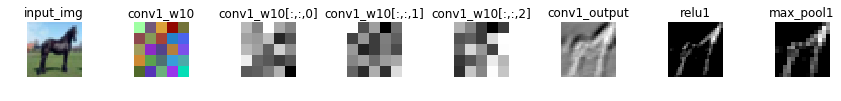

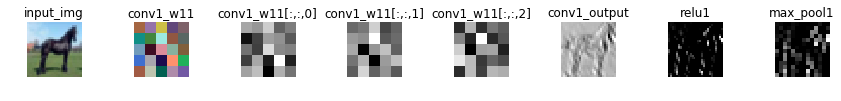

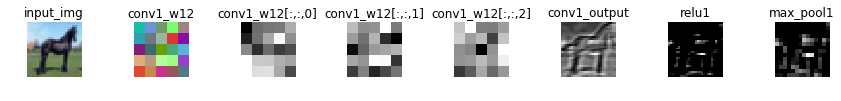

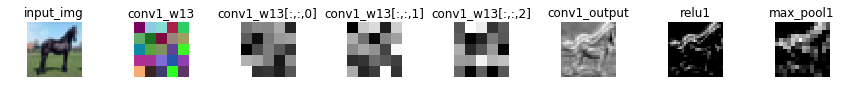

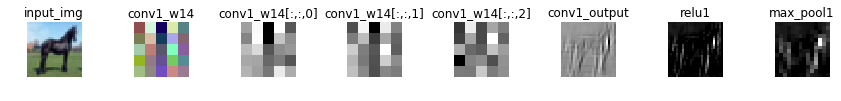

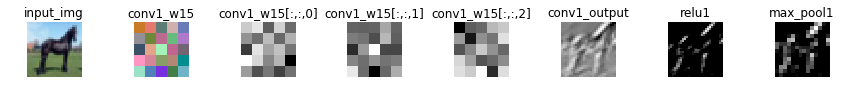

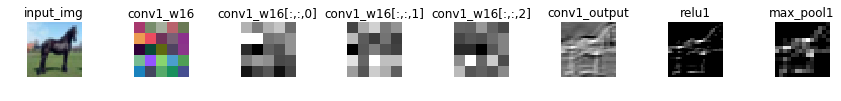

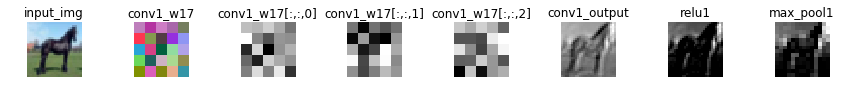

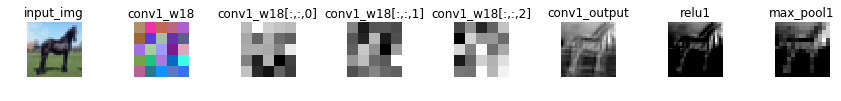

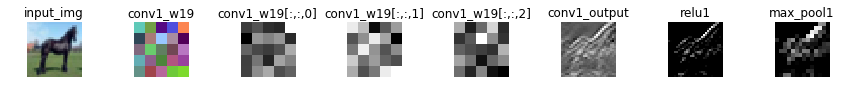

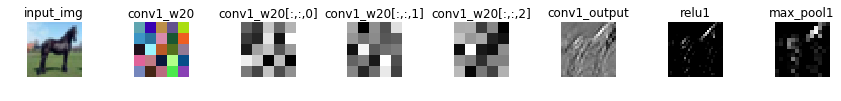

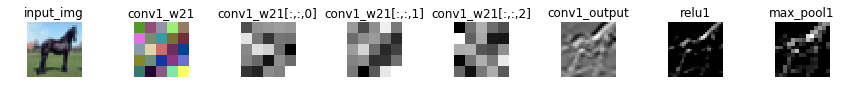

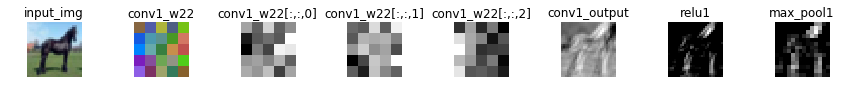

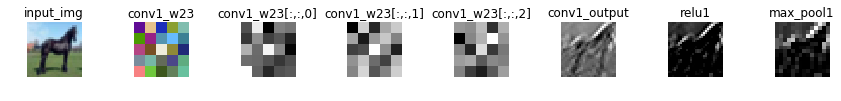

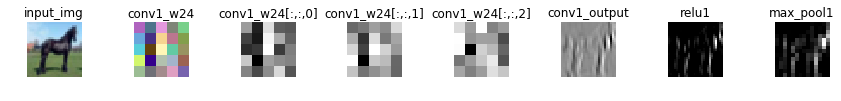

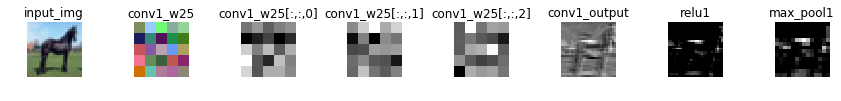

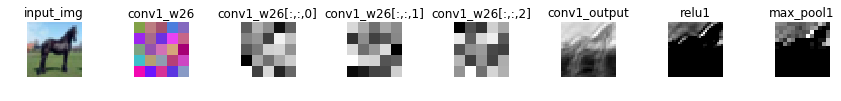

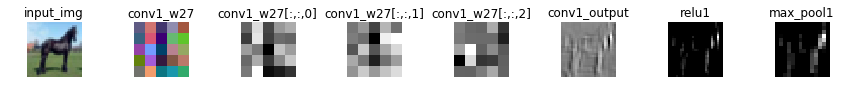

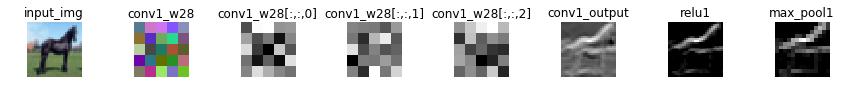

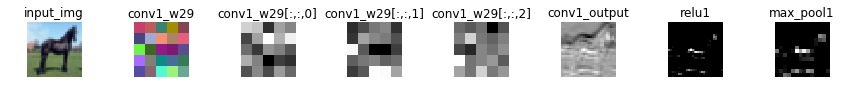

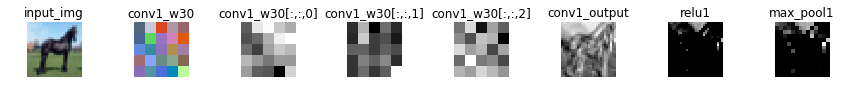

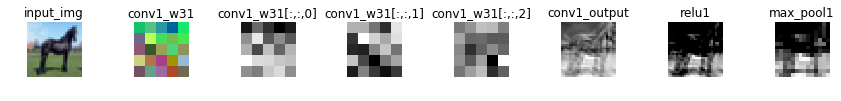

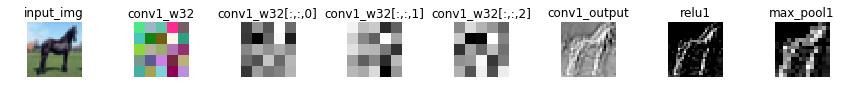

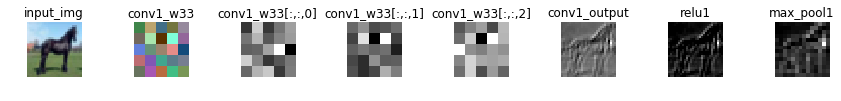

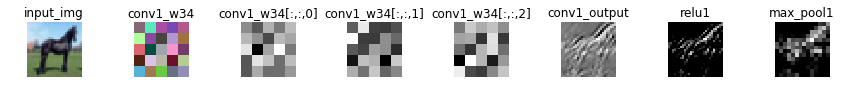

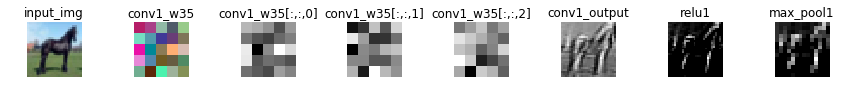

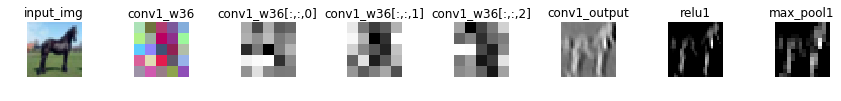

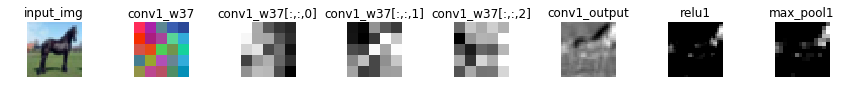

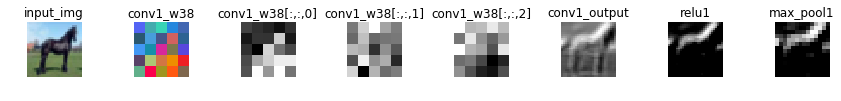

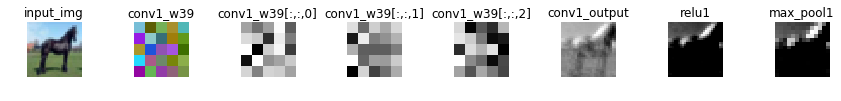

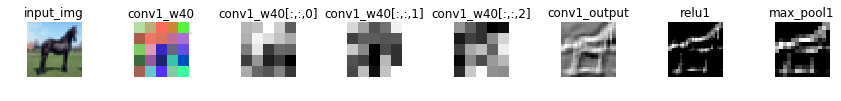

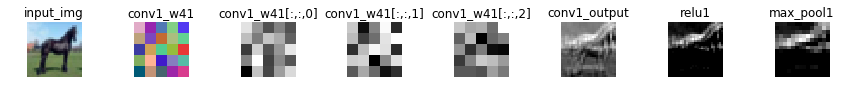

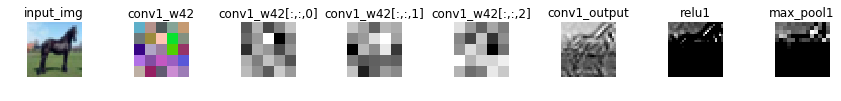

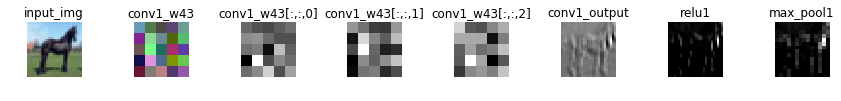

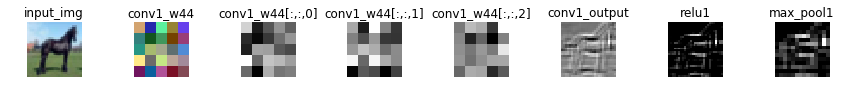

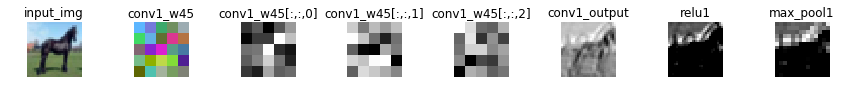

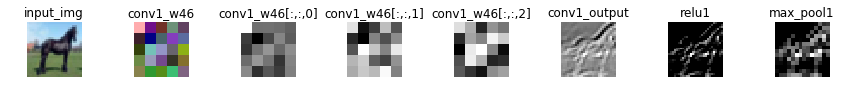

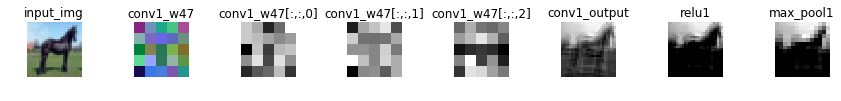

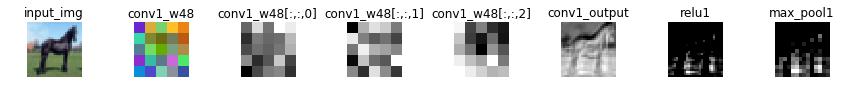

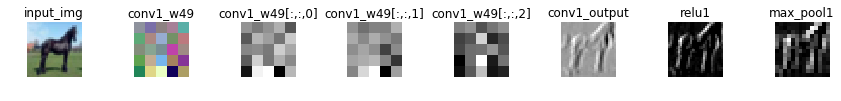

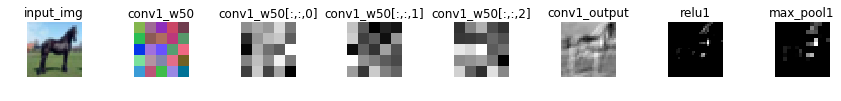

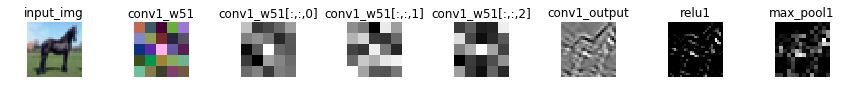

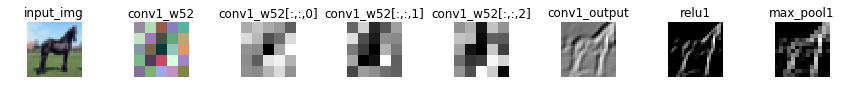

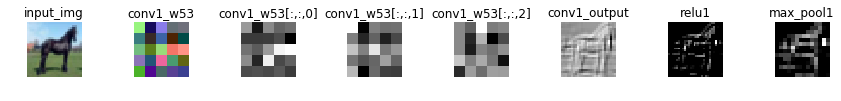

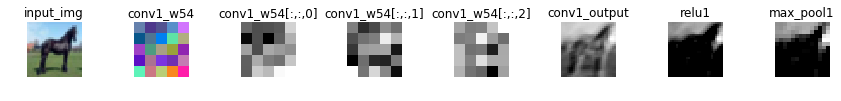

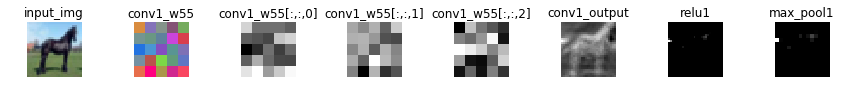

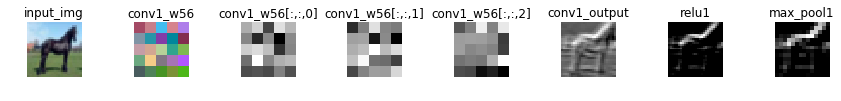

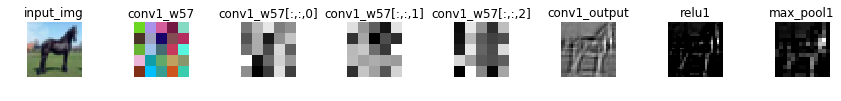

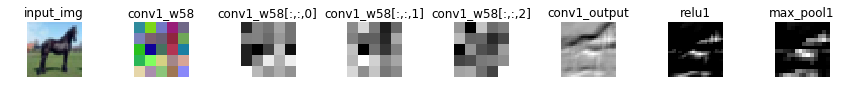

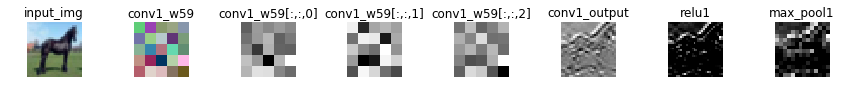

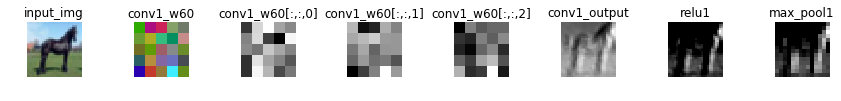

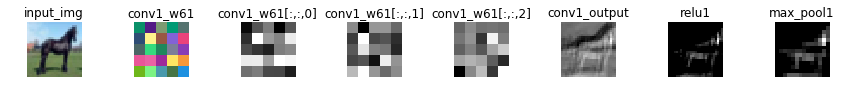

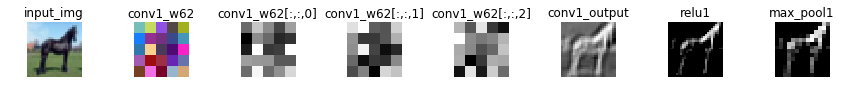

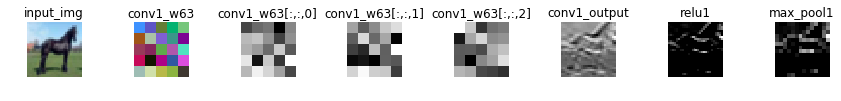

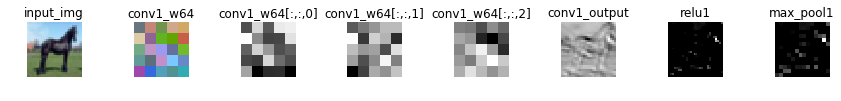

In [12]:
for i in range(conv1_w.shape[-1]):
    plt.figure(figsize=(15, 1))
    num_subplots = 8
    
    plt.subplot(1, num_subplots, 1)
    plt.imshow(normalize_img(x[0]))
    plt.axis('off')
    plt.title('input_img')

    plt.subplot(1, num_subplots, 2)
    plt.imshow(normalize_img(conv1_w[:,:,:,i]))
    plt.axis('off')
    plt.title(f'conv1_w{i+1}')
    
    plt.subplot(1, num_subplots, 3)
    plt.imshow(normalize_img(conv1_w[:,:,0,i]), cmap='gray')
    plt.axis('off')
    plt.title(f'conv1_w{i+1}[:,:,0]')
    
    plt.subplot(1, num_subplots, 4)
    plt.imshow(normalize_img(conv1_w[:,:,1,i]), cmap='gray')
    plt.axis('off')
    plt.title(f'conv1_w{i+1}[:,:,1]')

    plt.subplot(1, num_subplots, 5)
    plt.imshow(normalize_img(conv1_w[:,:,2,i]), cmap='gray')
    plt.axis('off')
    plt.title(f'conv1_w{i+1}[:,:,2]')
    
    plt.subplot(1, num_subplots, 6)
    plt.imshow(normalize_img(conv1[0,:,:,i]), cmap='gray')
    plt.axis('off')
    plt.title('conv1_output')
    
    plt.subplot(1, num_subplots, 7)
    plt.imshow(normalize_img(relu1[0,:,:,i]), cmap='gray')
    plt.axis('off')
    plt.title('relu1')
    
    plt.subplot(1, num_subplots, 8)
    plt.imshow(normalize_img(max_pool1[0,:,:,i]), cmap='gray')
    plt.axis('off')
    plt.title('max_pool1')
    
    plt.show()